In [68]:
from self_supervised.pipelines.representation_model import RepresentationModel, YoloEncoder
from yolov5.models.yolo import DetectionModel
import torch

%reload_kedro
model_description = catalog.load("yolov5_l_description")
trained_model = catalog.load("trained_model")

# Random model
#encoder = YoloEncoder(model_description=model_description)
#trained_model = RepresentationModel(encoder=encoder)

# CoCO model
#model_description["head"] = model_description["head"][:-1]
#trained_model = DetectionModel(model_description)
#weights_model = torch.load("../yolov5l.pt", map_location="cpu")
#state_dict = weights_model["model"].float().state_dict()
#trained_model.load_state_dict(state_dict, strict=False)

trained_model = trained_model.encoder
trained_model = trained_model.eval()

2023-03-13 10:21:29,967 - kedro.ipython - INFO - Resolved project path as: /home/daniel/git/self-supervised-learning.
To set a different path, run '%reload_kedro <project_root>'
2023-03-13 10:21:29,971 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/kedro/framework/startup.py:98: DeprecationWarning: project_version in pyproject.toml is deprecated, use kedro_init_version instead
  warnings.warn(

2023-03-13 10:21:30,074 - kedro.ipython - INFO - Kedro project Self-Supervised Learning
2023-03-13 10:21:30,074 - kedro.ipython - INFO - Defined global variable 'context', 'session', 'catalog' and 'pipelines'
2023-03-13 10:21:30,079 - kedro.io.data_catalog - INFO - Loading data from 'yolov5_l_description' (YAMLDataSet)...
2023-03-13 10:21:30,084 - kedro.io.data_catalog - INFO - Loading data from 'trained_model' (PytorchModelDataSet)...


2023-03-13 10:21:30.085 | WARNING  | self_supervised.extras.datasets.pytorch_model_data_set:_load:42 - CUDA not available, automatically mapping variables to the CPU.


In [69]:
from pathlib import Path

dataset_path = Path("/home/daniel/lab_share/projects/CottonFlower2021/flower_dataset")
image_dir = dataset_path / "active_1" / "images"

In [70]:
from torchvision.io import read_image
from torchvision.transforms.functional import resize
from tqdm import tqdm
import torch

image_reps = []

image_list = sorted(list(image_dir.iterdir()))
for image_path in tqdm(image_list):
    image = read_image(image_path.as_posix())
    image.requires_grad = False
    image = resize(image, (512, 512))
    image = image.to(torch.float) / 255
    image_ex = image[None, :, :, :]
    
    image_reps.append(trained_model(image_ex)[0].detach().reshape((1, -1)).numpy())

100%|████████████████████████████████████████████████████| 160/160 [00:22<00:00,  7.03it/s]


In [71]:
# Load flower counts.
import pandas as pd

labels_dir = dataset_path / "active_1" / "labels"
all_labels = []
labels_list = sorted(list(labels_dir.iterdir()))
for labels_path in labels_list:
    frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
    frame_labels["frame"] = labels_path.name
    all_labels.append(frame_labels)
    
all_labels = pd.concat(all_labels, ignore_index=True)
all_labels

,class,x,y,width,height,frame
0,0,0.386324,0.308469,0.030488,0.046636,p0_P1090018.txt
1,0,0.284843,0.252320,0.026132,0.038283,p0_P1090081.txt
2,0,0.448606,0.327726,0.013937,0.029002,p0_P1090300.txt
3,0,0.138937,0.221578,0.023519,0.032483,p0_P1090300.txt
4,0,0.030488,0.099768,0.024390,0.034803,p0_P1090300.txt
...,...,...,...,...,...,...
300,0,0.309612,0.294762,0.010253,0.014188,p9_P1680757.txt
301,0,0.365584,0.297645,0.009460,0.017842,p9_P1680757.txt
302,0,0.500000,0.379350,0.013937,0.016241,p9_P1680757.txt
303,0,0.908537,0.736079,0.012195,0.017401,p9_P1680757.txt


In [72]:
import numpy as np

# Create flower counts labels.
flower_counts = []
for image_path in labels_list:
    flower_counts.append(np.count_nonzero(all_labels["frame"] == image_path.name))
    
# Any missing counts are zeros.
for _ in range(len(flower_counts), len(image_reps)):
    flower_counts.append(0)

In [73]:
test_image_dir = dataset_path / "2018-08-22" / "images"

test_image_reps = []

image_list = sorted(list(test_image_dir.iterdir()))
for image_path in tqdm(image_list):
    image = read_image(image_path.as_posix())
    image.requires_grad = False
    image = resize(image, (512, 512))
    image = image.to(torch.float) / 255
    image_ex = image[None, :, :, :]
    
    test_image_reps.append(trained_model(image_ex)[0].detach().reshape((1, -1)).numpy())

100%|████████████████████████████████████████████████████| 160/160 [00:23<00:00,  6.87it/s]


In [74]:
test_labels_dir = dataset_path / "2018-08-22" / "labels"
all_labels_test = []
labels_list = sorted(list(test_labels_dir.iterdir()))
for labels_path in labels_list:
    frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
    frame_labels["frame"] = labels_path.name
    all_labels_test.append(frame_labels)
    
all_labels_test = pd.concat(all_labels_test, ignore_index=True)
all_labels_test

,class,x,y,width,height,frame
0,0,0.414497,0.818287,0.039062,0.046296,p0_P2530585.txt
1,0,0.245660,0.649884,0.019097,0.028935,p0_P2530668.txt
2,0,0.636719,0.209491,0.018229,0.025463,p0_P2530668.txt
3,0,0.827691,0.566551,0.019965,0.026620,p0_P2530668.txt
4,0,0.392734,0.709734,0.022448,0.033588,p0_P2530668.txt
...,...,...,...,...,...,...
382,0,0.053385,0.823495,0.021701,0.028935,p9_P2540369.txt
383,0,0.441840,0.266204,0.019097,0.025463,p9_P2540369.txt
384,0,0.533854,0.799769,0.032986,0.041667,p9_P2540420.txt
385,0,0.404948,0.767361,0.019965,0.025463,p9_P2540420.txt


In [75]:
# Create flower counts.
test_flower_counts = []
for image_path in labels_list:
    test_flower_counts.append(np.count_nonzero(all_labels_test["frame"] == image_path.name))
    
# Any missing counts are zeros.
for _ in range(len(test_flower_counts), len(test_image_reps)):
    test_flower_counts.append(0)

In [76]:
# Create combined dataset.
all_image_reps = image_reps + test_image_reps
all_flower_counts = flower_counts + test_flower_counts
train_indices = np.arange(len(image_reps))
test_indices = np.arange(len(image_reps), len(all_image_reps))

In [77]:
from sklearn.linear_model import RidgeCV

all_flower_counts = np.array(all_flower_counts, dtype=float)
all_image_reps_arr = np.concatenate(all_image_reps, axis=0)

alphas = [1e-6, 1e-4, 0.01, 0.1, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]
reg = RidgeCV(alphas=alphas, cv=((train_indices, test_indices),)).fit(all_image_reps_arr, all_flower_counts)

2023-03-13 10:23:03,938 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=2.41405e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)



In [78]:
test_image_reps_arr = np.concatenate(test_image_reps, axis=0)
test_preds = reg.predict(test_image_reps_arr)
test_preds

array([     1.0002,      6.9982,      4.0006,  -0.0015793,      3.0002,  0.00068855,      1.0063,       3.001,      4.9929,   0.0017452,  0.00057411, -0.00019264,      5.9938,      1.0022,      5.9962,      3.9995,     0.99976,   0.0048294,      4.9961, -0.00087929,  -0.0018845,  -0.0003624,      5.9895,       2.003,
            2.0127,      1.0043,       2.004,      1.0057,      2.9999,   0.0024185,      2.0003,      7.9967,      2.9965,       3.002,      2.0037,      2.9994,      2.0005,      2.0006,      1.9988,      1.0063,      2.0005,   0.0009861,      7.9933,      2.0033,      1.0049,      12.989,      2.0018,      1.0012,
            1.0012,  0.00083542,           1, -0.00049973,      4.9885,      3.0026,      2.0041,      5.9991,      1.0012,    0.015297,      1.0059,      1.9978,  -0.0010071,  -0.0003624,       3.008,      2.9995,      2.0173,      13.981,      2.9955,      1.9994,      2.0004,      4.9953,      1.0021,      3.0007,
            5.0015,      2.9998,      2.0006,       2.005,      13.984,      2.9979,      2.0012, -4.3869e-05,   0.0017319,  -9.346e-05,      5.0012,      1.0014,      2.0106,      2.9973,       4.004,   0.0024452,      3.9962,  0.00037003,   0.0003376,  -0.0026245,       5.971,  0.00069046,      3.9886,           3,
            3.9887,      2.0011,       2.004,  -0.0012741,      1.0022,      11.988,      2.9978,      2.9991,      2.9992,   0.0016384,      4.0008,      2.0014,      5.9799,  0.00098038,  0.00035858,      4.9981,      1.9973,      2.0026,      2.0019,     0.99874,      1.0075,      3.9995,   0.0019207,  0.00052071,
         0.0018368, -0.00029182,      2.0003,      3.0031,      4.0032,   0.0015011,      4.9952,      1.0026,      4.9961,  0.00073624,   0.0012112, -0.00096321,      6.9916,      2.0012,      2.0022,      4.9992,   0.0067654,      1.0003,      2.0018, -0.00080109,      2.9992,      3.9989,      2.0021,  0.00086212,
            2.9992,     0.00214,   0.0040684,      1.9997,      3.9997,      1.0021,  -0.0018311,      1.9987,      4.0008,      2.9994,      2.0016,      6.0007,      2.0042,      1.0015,      2.9992,      2.9993], dtype=float32)

In [79]:
errors = test_preds - test_flower_counts
np.mean(np.abs(errors))

0.003145742416381836

2023-03-13 10:23:44,007 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":

2023-03-13 10:23:44,007 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)



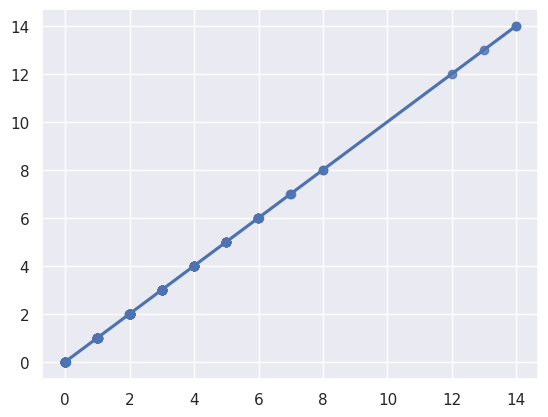

In [80]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

sns.regplot(x=test_preds, y=test_flower_counts)
plt.show()

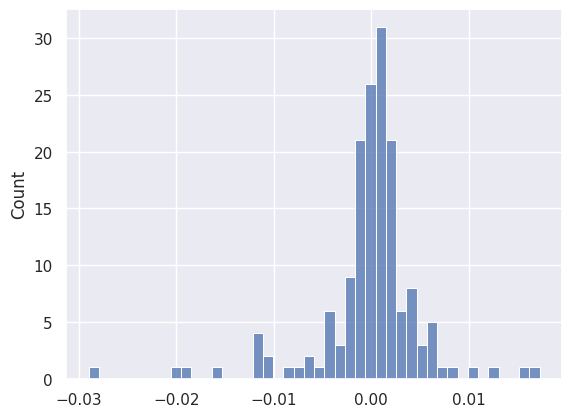

In [81]:
sns.histplot(x=errors)

In [82]:
import numpy as np

# Use the coefficient of variation of the differences between frames to provide a measure of "smoothness".
gt_diff = np.diff(test_flower_counts)
gt_smoothness = np.std(gt_diff) / np.abs(np.mean(gt_diff))
gt_smoothness

301.705982705017

In [83]:
pred_diff = np.diff(test_preds)
pred_smoothness = np.std(pred_diff) / np.abs(np.mean(pred_diff))
pred_smoothness

301.40784

In [84]:
reps_diff = np.diff(test_image_reps_arr, axis=0)
reps_smoothness = np.std(reps_diff, axis=0) / np.abs(np.mean(reps_diff, axis=0))
np.mean(reps_smoothness)

3815.266